# 주제: LSTM을 통해 주가 예측 모델 구현하기

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from tqdm import tqdm
import FinanceDataReader as fdr
import tensorflow as tf

In [4]:
%matplotlib inline
warnings.filterwarnings('ignore')

In [5]:
plt.rcParams['font.family']='NaumGothic'

# FinanceDataReader
# 한국 주식 가격, 미국주식 가격, 지수, 환율, 암호화폐 가격, 종목 리스팅 등 금융 데이터 수집 라이브러리

In [6]:
# 삼성전자 주가 데이터 Load
samsung=fdr.DataReader('005930')

In [7]:
samsung #6000개의 row로 이루어져있음

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-09-26,718,733,712,730,299970,NaN
1998-09-28,741,756,712,713,543070,-0.023288
1998-09-29,715,747,709,747,587660,0.047686
1998-09-30,737,745,720,728,482440,-0.025435
1998-10-01,720,724,700,705,389970,-0.031593
...,...,...,...,...,...,...
2022-12-23,58200,58400,57700,58100,9829407,-0.016920
2022-12-26,58000,58100,57700,57900,6756411,-0.003442
2022-12-27,58000,58400,57900,58100,10667027,0.003454


# 테이블 정의서

open: 시가

High: 고가

Low: 저가

Close: 종가

Volume: 거래량

Change: 대비


In [8]:
samsung.describe()

,Open,High,Low,Close,Volume,Change
count,6000.000000,6000.000000,6000.000000,6000.000000,6.000000e+03,5999.000000
mean,24837.284333,25091.522500,24578.157833,24858.172833,3.446046e+06,0.001001
std,20778.769274,20950.093972,20598.814449,20765.755797,7.075201e+06,0.023628
min,0.000000,0.000000,0.000000,705.000000,0.000000e+00,-0.137566
25%,9490.000000,9600.000000,9330.000000,9487.500000,2.935750e+05,-0.011480
50%,16300.000000,16480.000000,16120.000000,16350.000000,4.929690e+05,0.000000
75%,33240.000000,33675.000000,32740.000000,33635.000000,1.051727e+06,0.012343
max,90300.000000,96800.000000,89500.000000,91000.000000,9.030618e+07,0.150000


In [9]:
LG=fdr.DataReader('066570')

In [10]:
LG

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2002-04-22,55509,63815,55509,62936,8151792,NaN
2002-04-23,60688,61372,57170,57464,5384435,-0.086945
2002-04-24,58147,59418,53065,55705,4659371,-0.030610
2002-04-25,53750,55118,50622,51209,3913730,-0.080711
2002-04-26,50622,54727,49156,53555,4176615,0.045812
...,...,...,...,...,...,...
2022-12-23,88500,92200,88200,90900,946249,0.006645
2022-12-26,90900,91000,88700,88900,466302,-0.022002
2022-12-27,89500,90400,89100,89700,553886,0.008999


In [11]:
Kia=fdr.DataReader('000270')

In [12]:
Kia

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-09-26,8537,8537,8394,8393,109720,NaN
1998-09-28,8966,8966,8155,8680,182830,0.034195
1998-09-29,8585,8632,8489,8584,143490,-0.011060
1998-09-30,8585,8775,8585,8727,237200,0.016659
1998-10-01,8489,8728,8489,8489,125050,-0.027272
...,...,...,...,...,...,...
2022-12-23,62600,63300,62500,62700,772642,-0.012598
2022-12-26,63100,63900,62700,63700,856734,0.015949
2022-12-27,64000,64300,63500,64100,1200679,0.006279


In [13]:
# 삼성, LG, KIA

In [14]:
# 년도별, 월별, 일별 Split
samsung['Year']=samsung.index.year
samsung['Month']=samsung.index.month
samsung['Day']=samsung.index.day

In [15]:
samsung

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1998-09-26,718,733,712,730,299970,NaN,1998,9,26
1998-09-28,741,756,712,713,543070,-0.023288,1998,9,28
1998-09-29,715,747,709,747,587660,0.047686,1998,9,29
1998-09-30,737,745,720,728,482440,-0.025435,1998,9,30
1998-10-01,720,724,700,705,389970,-0.031593,1998,10,1
...,...,...,...,...,...,...,...,...,...
2022-12-23,58200,58400,57700,58100,9829407,-0.016920,2022,12,23
2022-12-26,58000,58100,57700,57900,6756411,-0.003442,2022,12,26
2022-12-27,58000,58400,57900,58100,10667027,0.003454,2022,12,27


In [16]:
samsung.groupby(['Year']).mean()

,Open,High,Low,Close,Volume,Change,Month,Day
Year,,,,,,,,
1998,1145.575342,1180.589041,1116.356164,1150.958904,9.694678e+05,0.011464,10.835616,16.232877
1999,3042.759036,3131.196787,2968.831325,3046.895582,8.627532e+05,0.005742,6.578313,15.582329
2000,5382.593361,5516.601660,5248.804979,5372.406639,1.118580e+06,-0.001001,6.464730,16.120332
2001,3993.719512,4071.313008,3927.918699,4003.617886,7.313713e+05,0.002954,6.524390,16.004065
2002,6859.209016,6971.897541,6752.295082,6865.122951,8.511943e+05,0.000935,6.524590,16.004098
2003,7446.457490,7545.068826,7352.323887,7454.453441,6.190000e+05,0.001734,6.493927,15.931174
2004,9647.698795,9765.811245,9523.477912,9647.389558,5.721826e+05,0.000240,6.618474,15.602410
2005,10729.016064,10835.558233,10634.220884,10739.236948,4.305591e+05,0.001628,6.578313,15.975904
2006,12769.429150,12893.870445,12637.829960,12758.056680,3.951112e+05,-0.000184,6.469636,15.906883


Text(0.5, 0, 'Date')

findfont: Font family ['NaumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NaumGothic'] not found. Falling back to DejaVu Sans.


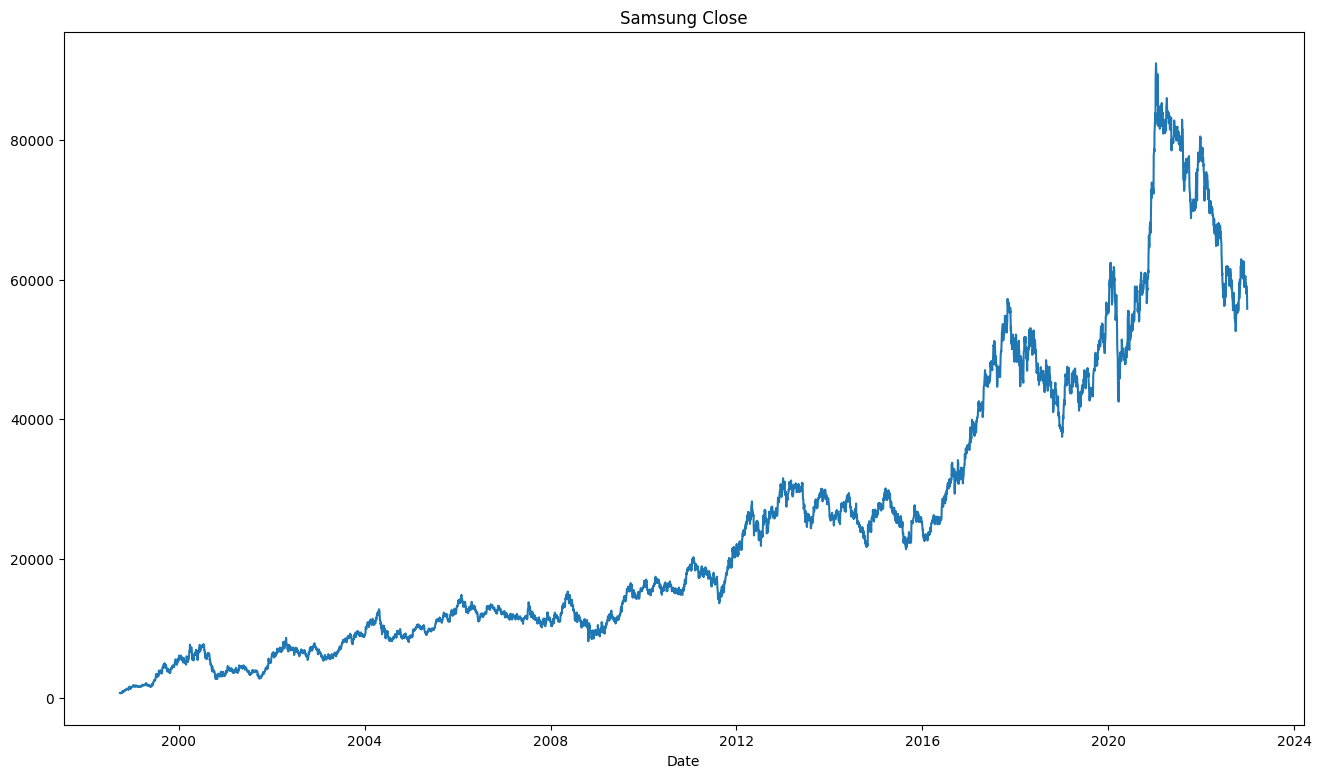

In [17]:
# 그래프 시각화

plt.figure(figsize=(16,9))
plt.plot(samsung['Close'])
plt.title('Samsung Close')
plt.xlabel('Date')

In [18]:
# 5년단위로 끊어서 4개의 Plot Graph
time_step=[['1998','2002'],
          ['2002','2008'],
          ['2008','2015'],
          ['2015','2022'],
          ]

In [19]:
time_step[0][1]

'2002'

In [20]:
samsung.loc[(samsung.index >= time_step[0][0]) & (samsung.index < time_step[0][1])]

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1998-09-26,718,733,712,730,299970,NaN,1998,9,26
1998-09-28,741,756,712,713,543070,-0.023288,1998,9,28
1998-09-29,715,747,709,747,587660,0.047686,1998,9,29
1998-09-30,737,745,720,728,482440,-0.025435,1998,9,30
1998-10-01,720,724,700,705,389970,-0.031593,1998,10,1
...,...,...,...,...,...,...,...,...,...
2001-12-21,5100,5190,5000,5030,833009,-0.050943,2001,12,21
2001-12-24,5050,5160,5010,5050,408625,0.003976,2001,12,24
2001-12-26,5130,5190,5080,5160,434969,0.021782,2001,12,26


AxesSubplot(0.125,0.53;0.352273x0.35)
AxesSubplot(0.547727,0.53;0.352273x0.35)
AxesSubplot(0.125,0.11;0.352273x0.35)
AxesSubplot(0.547727,0.11;0.352273x0.35)


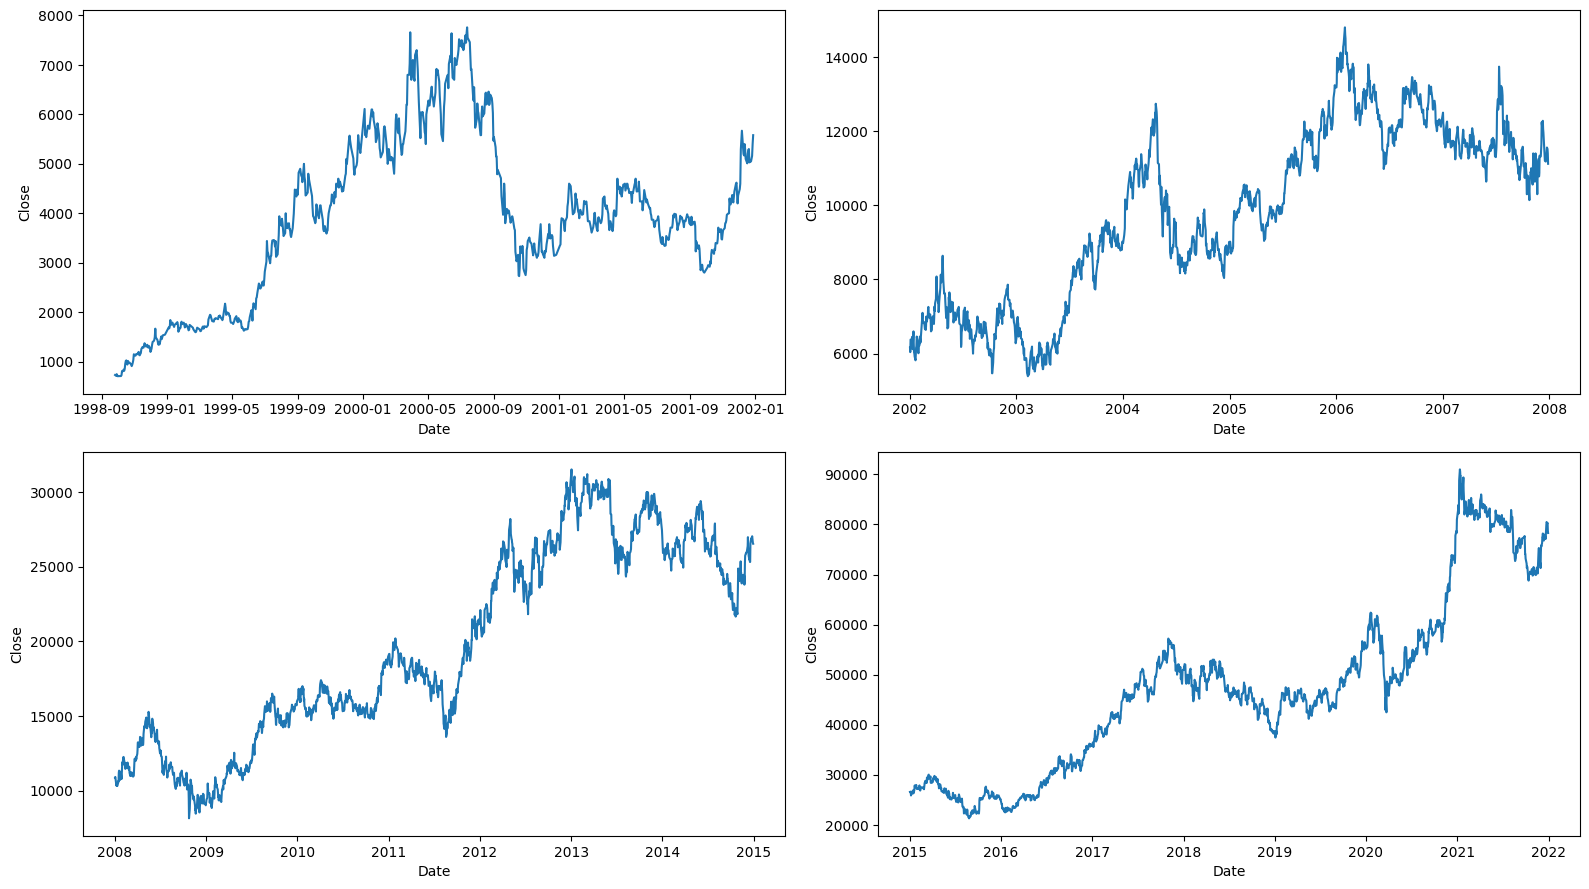

In [21]:
fig, axes =plt.subplots(2,2)
fig.set_size_inches(16,9)


for i in range(4):
    ax=axes[i//2,i%2]
    print(ax)
    df=samsung.loc[(samsung.index >= time_step[i][0]) & (samsung.index < time_step[i][1])]
    sns.lineplot(y=df['Close'],x=df.index, data=df, ax=ax)
    
plt.tight_layout()
plt.show()

In [22]:
# Data Preprocessing
# Data 표준화

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
scaler=MinMaxScaler()

# Change=전날 대비 거래량빼고 모두 표준화

In [25]:
col_list=['Open','High','Low','Close','Volume']

In [26]:
scaled_data=scaler.fit_transform(samsung[col_list])
scaled_data #표준화 데이터

array([[7.95127353e-03, 7.57231405e-03, 7.95530726e-03, 2.76870259e-04,
        3.32169969e-03],
       [8.20598007e-03, 7.80991736e-03, 7.95530726e-03, 8.85984828e-05,
        6.01365286e-03],
       [7.91805094e-03, 7.71694215e-03, 7.92178771e-03, 4.65142034e-04,
        6.50741754e-03],
       ...,
       [6.42303433e-01, 6.03305785e-01, 6.46927374e-01, 6.35638740e-01,
        1.18120680e-01],
       [6.37873754e-01, 5.95041322e-01, 6.30167598e-01, 6.19026524e-01,
        1.62396532e-01],
       [6.20155039e-01, 5.80578512e-01, 6.22346369e-01, 6.10166676e-01,
        4.95761658e-02]])

In [27]:
samsung_scaled=pd.DataFrame(scaled_data,columns=col_list)

In [28]:
samsung_scaled

,Open,High,Low,Close,Volume
0,0.007951,0.007572,0.007955,0.000277,0.003322
1,0.008206,0.007810,0.007955,0.000089,0.006014
2,0.007918,0.007717,0.007922,0.000465,0.006507
3,0.008162,0.007696,0.008045,0.000255,0.005342
4,0.007973,0.007479,0.007821,0.000000,0.004318
...,...,...,...,...,...
5995,0.644518,0.603306,0.644693,0.635639,0.108845
5996,0.642303,0.600207,0.644693,0.633424,0.074817
5997,0.642303,0.603306,0.646927,0.635639,0.118121
5998,0.637874,0.595041,0.630168,0.619027,0.162397


# Train, Test 셋으로 Split

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
# 종가를 예측하기 위해 종가 컬럼 추출
# Train:Test 비율은 8:2로 지정
# 시계열 데이터 이기 때문에 Shuffle은 해주지 않음

In [31]:
samsung_x_train, samsung_x_test, samsung_y_train, samsung_y_test=train_test_split(samsung_scaled.drop('Close',axis=1), samsung_scaled['Close'],test_size=0.2,random_state=0)

In [32]:
samsung_x_train

,Open,High,Low,Volume
3381,0.289037,0.274174,0.291397,0.003348
31,0.012824,0.012004,0.012492,0.012218
1596,0.113400,0.106198,0.111508,0.005544
1386,0.114064,0.109504,0.114190,0.010027
4237,0.306755,0.287810,0.307028,0.004280
...,...,...,...,...
4931,0.519934,0.495351,0.521788,0.135021
3264,0.209967,0.198347,0.208939,0.003400
1653,0.107198,0.100207,0.107263,0.005344
2607,0.132226,0.124587,0.131397,0.007248


In [33]:
'''
위의 방식처럼 데이터를 랜덤으로 섞어 Train, Test를 나누는 경우가 많지만 미래를 예측해야하는
시계열의 경우 특정시점에서 잘라서 예측하는 것이 더 바람직하기 때문에
8:2 비율이 되는 시점에서 데이서 셋을 잘라줄 예정
'''

'\n위의 방식처럼 데이터를 랜덤으로 섞어 Train, Test를 나누는 경우가 많지만 미래를 예측해야하는\n시계열의 경우 특정시점에서 잘라서 예측하는 것이 더 바람직하기 때문에\n8:2 비율이 되는 시점에서 데이서 셋을 잘라줄 예정\n'

In [34]:
print(len(samsung_scaled))
#Train=4800개
#Test=1200개

6000


# Data Split

In [35]:
type(samsung_scaled)

pandas.core.frame.DataFrame

In [36]:
# Train Test 나누기
Train=[]
Test=[]


for i in tqdm(range(len(samsung_scaled))):
    if i < 4800:
        Train.append(samsung_scaled.loc[i])
    elif i >= 4800:
        Test.append(samsung_scaled.loc[i])
    else:
        pass

Train=pd.DataFrame(Train)
Test=pd.DataFrame(Test)

100%|███████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 20269.78it/s]


In [37]:
print(len(Train))
print(len(Test))

4800
1200


In [38]:
Train.head()

,Open,High,Low,Close,Volume
0,0.007951,0.007572,0.007955,0.000277,0.003322
1,0.008206,0.007810,0.007955,0.000089,0.006014
2,0.007918,0.007717,0.007922,0.000465,0.006507
3,0.008162,0.007696,0.008045,0.000255,0.005342
4,0.007973,0.007479,0.007821,0.000000,0.004318


In [39]:
Test.head()

,Open,High,Low,Close,Volume
4800,0.551495,0.514463,0.534749,0.527992,0.003400
4801,0.532004,0.497521,0.527598,0.517138,0.002242
4802,0.523588,0.491529,0.523352,0.515809,0.002853
4803,0.523367,0.488223,0.522458,0.510050,0.001964
4804,0.517829,0.493802,0.522458,0.515145,0.002751


# 종가로 주가 예측 진행

In [40]:
# window data set 설정

In [41]:
Train_close=Train['Close']
Test_close=Test['Close']

In [59]:
X_test=Train[['Close']]
Y_test=Test[['Close']]

# windowed data set

종가 데이터만 활용하여 windowed dataset-> 과거 5,10일치 데이터로 다음 날 주가 예측하는 데이터 형태

series=종가데이터 입력

window_size=과거 며칠치를 볼지

batch_size=배치 사이즈

In [42]:
def window_module(series,window_size,batch_size,shuffle):
    series=tf.expand_dims(series,axis=1) #종가데이터 입력, 차원 1개 늘려줌
    ds=tf.data.Dataset.from_tensor_slices(series) #Tensor 변환
    ds=ds.window(window_size+1,shift=1, stride=1, drop_remainder=True) #window값과 y값을 포함해야하기 때문에 +1해줌,1칸씩이동하고 Drop True해줘서 꼬다리 데이터 안남게 해줌
    ds=ds.flat_map(lambda w: w.batch(window_size+1)) #배치사이즈만큼 데이터를 Flatten해줌
    if shuffle:
        ds=ds.shuffle(1000) #buffer size=1000, overfitting 방지를 위해 Train은 shuffle해줌, 전체 데이터 크기보다 크게해야 Random하게 잘 섞임
    ds=ds.map(lambda w: (w[:-1],w[-1])) #(x,y)형태로 코딩
    return ds.batch(batch_size).prefetch(1) #batch size만큼 데이터 묶음->병렬처리로 속도향상

In [43]:
# 모델 구현하기

In [44]:
# Hyper parameter 정의

window_size=20
batch_size=32

In [45]:
# Train, Test data에서 Close 컬럼만 추출하기
print(Train_close)
print(Test_close)

0       0.000277
1       0.000089
2       0.000465
3       0.000255
4       0.000000
          ...   
4795    0.501634
4796    0.487236
4797    0.498533
4798    0.518689
4799    0.534858
Name: Close, Length: 4800, dtype: float64
4800    0.527992
4801    0.517138
4802    0.515809
4803    0.510050
4804    0.515145
          ...   
5995    0.635639
5996    0.633424
5997    0.635639
5998    0.619027
5999    0.610167
Name: Close, Length: 1200, dtype: float64


In [46]:
# window dataset 생성 함수에 적용
train_data=window_module(Train_close,window_size,batch_size,True)
test_data=window_module(Test_close,window_size,batch_size,False)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [47]:
# window data check
for data in train_data.take(1):
    print(f'데이터셋(X_예측에 사용할 데이터) 구성(batch,window,feature): {data[0].shape}')
    print(f'데이터샛(Y값) 구성(batch,window,feature): {data[1].shape}')

데이터셋(X_예측에 사용할 데이터) 구성(batch,window,feature): (32, 20, 1)
데이터샛(Y값) 구성(batch,window,feature): (32, 1)


In [48]:
# 모델 구현 패키지 설치

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber #L1+L2 Loss->MSE, MAE 로스 혼합해서 씀
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 

In [69]:
# 모델 구현

model=Sequential([ #아래함수들을 Sequnetial하게 적용시켜줌 pytorch에서 Forward 같은 부분
    Conv1D(filters=32, kernel_size=5,#백터차원으로 데이터가 INPUT되기 떄문에 Conv1D 함수를 써줌, filter=출력차원=32, kernel_size=5->20일에서 5일간의 특성을 추출하여 분석한다는 의미.
          padding='causal',
          activation='relu',
          input_shape=[window_size,1] #20일치 x 데이터와 종가데이터 1개 만약 시가 등에 feature가 추가된다면 수만큼 설정해주면됨.
          ),
          LSTM(16), #16개 텐서값 추출
          Dense(16,activation='relu'), #Dense layer를 통해 텐서값 flatten
          Dense(1), #20일 데이터로 다음날 주가를 예측할것이기 때문에 Dense(1로)
          # Lambda(lambda x:x *20), #결과값에 20곱해줌
          
    
])

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 32)            192       
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,617
Trainable params: 3,617
Non-trainable params: 0
_________________________________________________________________


In [51]:
# 손실함수 정의 및 학습을 위해 모델 compile

loss=Huber() #Mse와 Mae Loss를 같이 써주는 손실함수

model.compile(optimizer='adam',loss=loss,metrics=['mae'])

In [52]:
# earlystopping->학습이 계속해서 개선되지 않을시에 학습을 끝내주는 옵션이라고 보면됨.
earlystopping=EarlyStopping(monitor='val_loss',patience=10) #10epoch 동안 loss가 개선되지 않을시 early stopping
# val loss 기준 체크포인터 생성
filename='tmp_checkpoint.ckpt' #제일 성능이좋은 모델저장, 확장자=ckpt->가중치만 저장하기 때문에
checkpoint=ModelCheckpoint(filepath=filename,
                          save_best_only=True, #best 모델만 저장
                          save_weights_only=True, #가중치만 저장
                          monitor='val_loss', #loss를 기준으로 저장함
                          verbose=1,
                          ) 

In [53]:
#callbacks로 앞에서 구현할 earlystopping과 checkpoint를 지정함
model.fit(train_data,validation_data=test_data,epochs=30,callbacks=[earlystopping, checkpoint])

Epoch 1/30
    142/Unknown - 2s 4ms/step - loss: 1.5344e-04 - mae: 0.0125
Epoch 1: val_loss improved from inf to 0.00177, saving model to tmp_checkpoint.ckpt
150/150 [==============================] - 3s 8ms/step - loss: 1.4962e-04 - mae: 0.0123 - val_loss: 0.0018 - val_mae: 0.0429
Epoch 2/30
144/150 [===========================>..] - ETA: 0s - loss: 3.0223e-05 - mae: 0.0056
Epoch 2: val_loss improved from 0.00177 to 0.00090, saving model to tmp_checkpoint.ckpt
150/150 [==============================] - 1s 5ms/step - loss: 3.4168e-05 - mae: 0.0059 - val_loss: 8.9673e-04 - val_mae: 0.0326
Epoch 3/30
146/150 [============================>.] - ETA: 0s - loss: 3.3845e-05 - mae: 0.0058
Epoch 3: val_loss improved from 0.00090 to 0.00067, saving model to tmp_checkpoint.ckpt
150/150 [==============================] - 1s 5ms/step - loss: 3.4492e-05 - mae: 0.0058 - val_loss: 6.7350e-04 - val_mae: 0.0267
Epoch 4/30
143/150 [===========================>..] - ETA: 0s - loss: 2.7790e-05 - mae: 0.005

In [54]:
# model check point 로드

model.load_weights(filename)

In [56]:
# 주가 예측 진행
pred=model.predict(test_data)

37/37 [==============================] - 0s 2ms/step


In [62]:
print(len(pred))
print(pred)

1180
[[0.55700934]
 [0.5563923 ]
 [0.5558156 ]
 ...
 [0.6325507 ]
 [0.6313993 ]
 [0.6237587 ]]


In [58]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [63]:
print(Test_close)
print(len(Test_close))

4800    0.527992
4801    0.517138
4802    0.515809
4803    0.510050
4804    0.515145
          ...   
5995    0.635639
5996    0.633424
5997    0.635639
5998    0.619027
5999    0.610167
Name: Close, Length: 1200, dtype: float64
1200


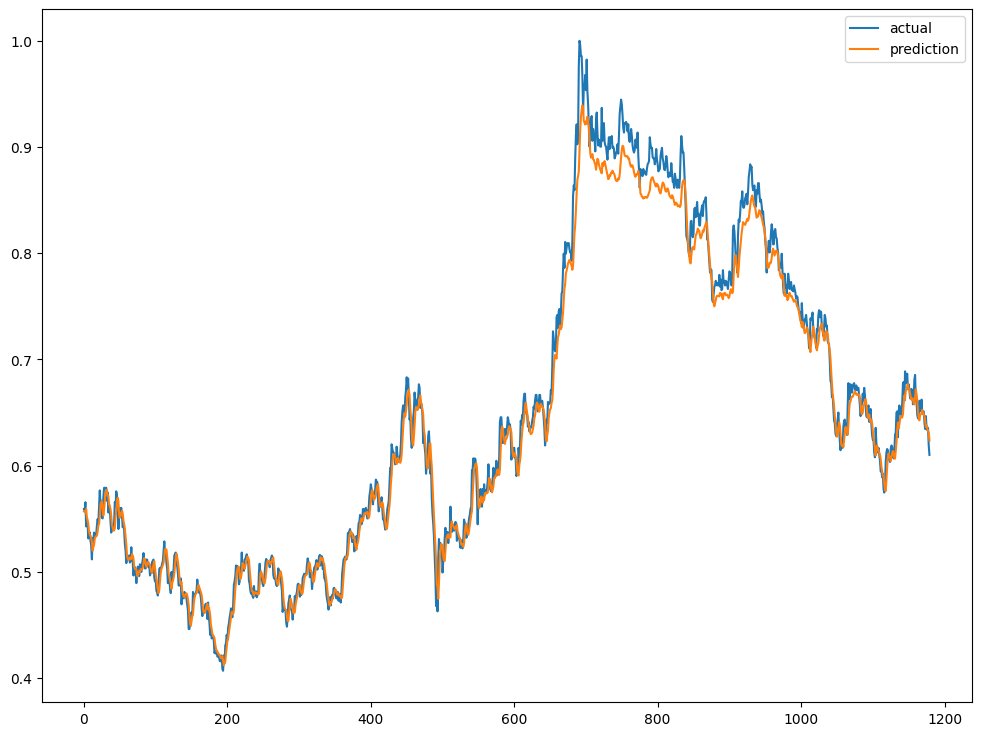

In [64]:
# visualization

plt.figure(figsize=(12,9))
plt.plot(np.asarray(Test_close)[20:],label='actual')#주가 실제값
plt.plot(pred,label='prediction')
plt.legend()
plt.show()

In [70]:
# 모델 튜닝
# 손실함수 정의 및 학습을 위해 모델 compile

loss=Huber() #Mse와 Mae Loss를 같이 써주는 손실함수
adam=Adam(learning_rate=0.0001)
model.compile(optimizer='adam',loss=loss,metrics=['mae'])

In [71]:
# earlystopping->학습이 계속해서 개선되지 않을시에 학습을 끝내주는 옵션이라고 보면됨.
earlystopping=EarlyStopping(monitor='val_loss',patience=10) #10epoch 동안 loss가 개선되지 않을시 early stopping
# val loss 기준 체크포인터 생성
filename='tmp_checkpoint.ckpt' #제일 성능이좋은 모델저장, 확장자=ckpt->가중치만 저장하기 때문에
checkpoint=ModelCheckpoint(filepath=filename,
                          save_best_only=True, #best 모델만 저장
                          save_weights_only=True, #가중치만 저장
                          monitor='val_loss', #loss를 기준으로 저장함
                          verbose=1,
                          ) 

In [72]:
#callbacks로 앞에서 구현할 earlystopping과 checkpoint를 지정함
model.fit(train_data,validation_data=test_data,epochs=40,callbacks=[earlystopping, checkpoint])

Epoch 1/40
    142/Unknown - 2s 4ms/step - loss: 1.0356e-04 - mae: 0.0102
Epoch 1: val_loss improved from inf to 0.00059, saving model to tmp_checkpoint.ckpt
150/150 [==============================] - 2s 7ms/step - loss: 1.0280e-04 - mae: 0.0101 - val_loss: 5.9419e-04 - val_mae: 0.0248
Epoch 2/40
142/150 [===========================>..] - ETA: 0s - loss: 2.9290e-05 - mae: 0.0056
Epoch 2: val_loss did not improve from 0.00059
150/150 [==============================] - 1s 5ms/step - loss: 3.0838e-05 - mae: 0.0057 - val_loss: 6.5778e-04 - val_mae: 0.0262
Epoch 3/40
149/150 [============================>.] - ETA: 0s - loss: 2.9547e-05 - mae: 0.0054
Epoch 3: val_loss improved from 0.00059 to 0.00045, saving model to tmp_checkpoint.ckpt
150/150 [==============================] - 1s 5ms/step - loss: 2.9734e-05 - mae: 0.0054 - val_loss: 4.5252e-04 - val_mae: 0.0229
Epoch 4/40
142/150 [===========================>..] - ETA: 0s - loss: 2.6781e-05 - mae: 0.0052
Epoch 4: val_loss did not improve f